In [1]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from graphviz import Source
from IPython.display import SVG
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [2]:
# reading csv file
df=pd.read_csv('/home/dell/Downloads/Loan payments data.csv')

In [3]:
# unique columns
df.columns.values

array(['Loan_ID', 'loan_status', 'Principal', 'terms', 'effective_date',
       'due_date', 'paid_off_time', 'past_due_days', 'age', 'education',
       'Gender'], dtype=object)

In [4]:
# unique labels
df.loan_status.unique()

array(['PAIDOFF', 'COLLECTION', 'COLLECTION_PAIDOFF'], dtype=object)

In [5]:
# Target distribution
df.loan_status.value_counts()

PAIDOFF               284
COLLECTION             85
COLLECTION_PAIDOFF     85
Name: loan_status, dtype: int64

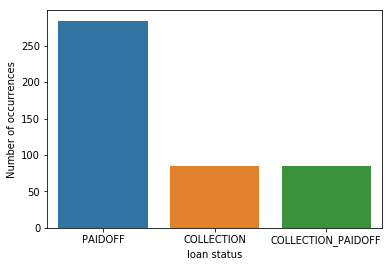

In [6]:
# Target variable exploration
sns.countplot(df.loan_status);
plt.xlabel('loan status');
plt.ylabel('Number of occurrences');
plt.show()

In [7]:
# check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 11 columns):
Loan_ID           454 non-null object
loan_status       454 non-null object
Principal         454 non-null int64
terms             454 non-null int64
effective_date    454 non-null object
due_date          454 non-null object
paid_off_time     369 non-null object
past_due_days     170 non-null float64
age               454 non-null int64
education         454 non-null object
Gender            454 non-null object
dtypes: float64(1), int64(3), object(7)
memory usage: 39.1+ KB


In [8]:
# basic statistical measures
df.describe()

,Principal,terms,past_due_days,age
count,454.000000,454.000000,170.000000,454.000000
mean,940.969163,22.625551,36.341176,30.973568
std,118.284029,8.055320,29.557507,6.103537
min,300.000000,7.000000,1.000000,18.000000
25%,900.000000,15.000000,3.000000,26.000000
50%,1000.000000,30.000000,44.000000,30.000000
75%,1000.000000,30.000000,60.000000,35.000000
max,1000.000000,30.000000,76.000000,51.000000


In [9]:
# dataframe view
df.head()

,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,09/08/16,10/07/16,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,09/08/16,10/07/16,10/07/16 9:00,NaN,50,Bechalor,female
2,xqd20160003,PAIDOFF,1000,30,09/08/16,10/07/16,9/25/2016 16:58,NaN,33,Bechalor,female
3,xqd20160004,PAIDOFF,1000,15,09/08/16,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,09/09/16,10/08/16,9/23/2016 21:36,NaN,28,college,female


In [10]:
# dealing with datetime
df['due_date']=pd.to_datetime(df['due_date'])
df['past_due_days']=pd.to_timedelta(df['past_due_days'],unit='D')
df['paid_off_time']=pd.to_datetime(df['paid_off_time'])
df['effective_date']=pd.to_datetime(df['effective_date'])

In [11]:
# extracting month and day from datetime object
df['month']=df['effective_date'].dt.month
df['day']=df['effective_date'].dt.day

In [12]:
# replace missing values with string for easier processing
df=df.fillna('nan')

In [13]:
# data cleaning
def replace_missing_dates(row):
    if row['paid_off_time']=='nan':
        return row['due_date']+row['past_due_days']
    else:    
        return row['paid_off_time']

In [14]:
# data cleaning
def replace_missing_days(row):
    if row['past_due_days']=='nan':
        j=(row['paid_off_time']-row['due_date']).days
        return int(j)
    else:    
        return int(row['past_due_days'].days)

In [15]:
# applying functons to all columns
df['paid_off_time']=df.apply(replace_missing_dates,axis=1)
df['past_due_days']=df.apply(replace_missing_days,axis=1)

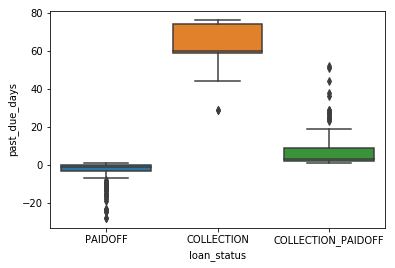

In [16]:
# boxplot
# important feature
sns.boxplot(x="loan_status", y="past_due_days", data=df)

/home/dell/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


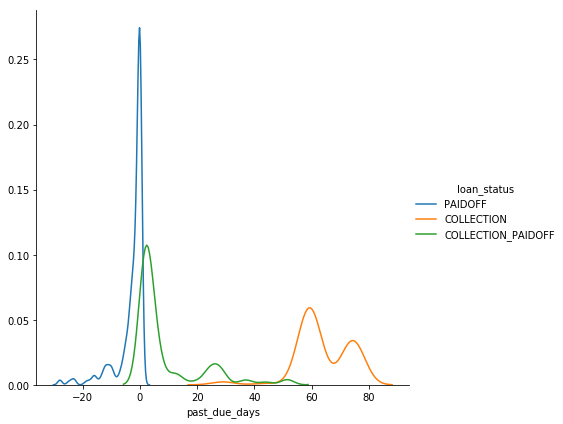

In [17]:
# kde plot
# best feature so far with almost seperable classes
sns.FacetGrid(df, hue="loan_status", size=6) \
   .map(sns.kdeplot, "past_due_days") \
   .add_legend()

In [18]:
# ax = df[df.loan_status=='PAIDOFF'].plot.scatter(x='terms',y='past_due_days',color='orange', label='paidoff')
# df[df.loan_status=='COLLECTION'].plot.scatter(x='terms',y='past_due_days',color='pink', label='collection',ax=ax)
# df[df.loan_status=='COLLECTION_PAIDOFF'].plot.scatter(x='terms',y='past_due_days',color='green', label='collectionpaidoff', ax=ax)
# ax.set_xlabel("Principal")
# ax.set_ylabel("past_due_days")
# ax.set_title("Relationship between Principal and past_due_days")

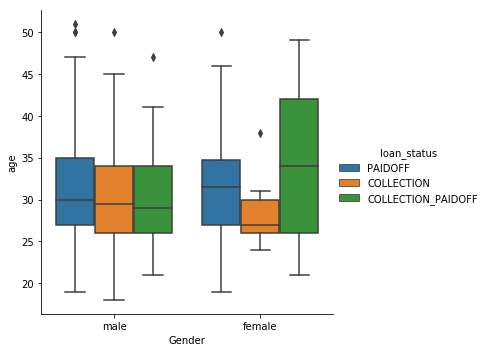

In [19]:
# visualizing categorical variables
sns.catplot(x="Gender",y="age",hue="loan_status", kind="box", data=df);

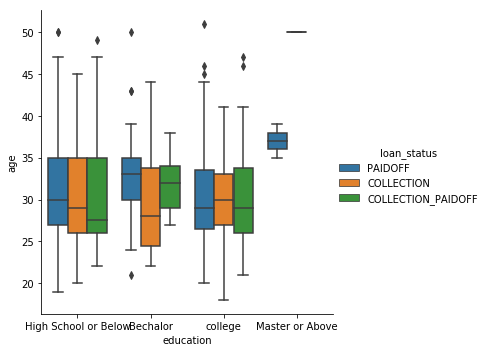

In [20]:
# visualizing categorical variables
sns.catplot(x="education",y="age",hue="loan_status", kind="box", data=df);

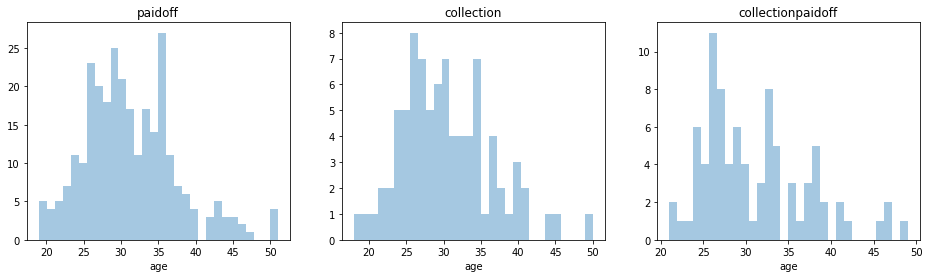

In [21]:
# visualizing continuous variables
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(df[df['loan_status']=='PAIDOFF'].age, bins = 30, ax = axes[0], kde = False)
ax.set_title('paidoff')
ax = sns.distplot(df[df['loan_status']=='COLLECTION'].age, bins = 30, ax = axes[1], kde = False)
ax.set_title('collection')
ax = sns.distplot(df[df['loan_status']=='COLLECTION_PAIDOFF'].age, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('collectionpaidoff')

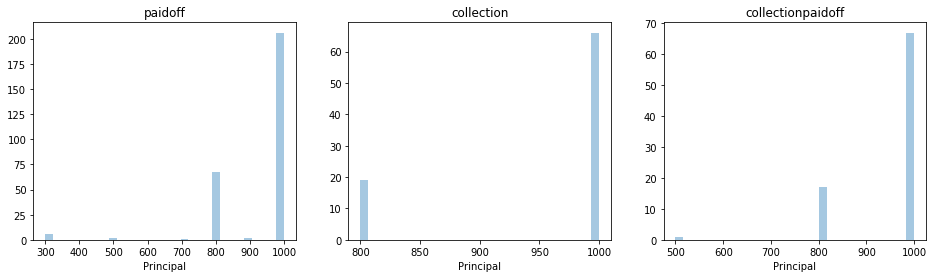

In [22]:
# visualizing continuous variables
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(df[df['loan_status']=='PAIDOFF'].Principal, bins = 30, ax = axes[0], kde = False)
ax.set_title('paidoff')
ax = sns.distplot(df[df['loan_status']=='COLLECTION'].Principal, bins = 30, ax = axes[1], kde = False)
ax.set_title('collection')
ax = sns.distplot(df[df['loan_status']=='COLLECTION_PAIDOFF'].Principal, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('collectionpaidoff')

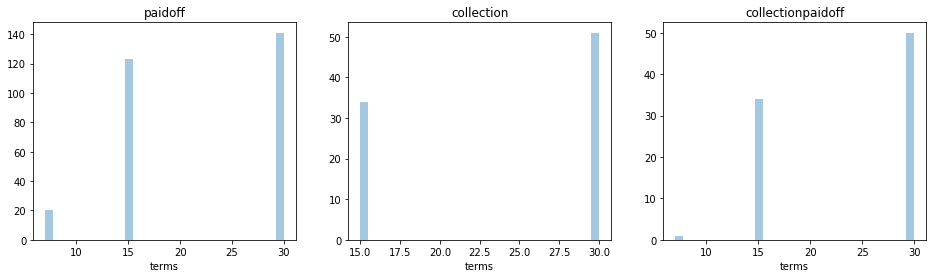

In [23]:
# visualizing continuous variables
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(df[df['loan_status']=='PAIDOFF'].terms, bins = 30, ax = axes[0], kde = False)
ax.set_title('paidoff')
ax = sns.distplot(df[df['loan_status']=='COLLECTION'].terms, bins = 30, ax = axes[1], kde = False)
ax.set_title('collection')
ax = sns.distplot(df[df['loan_status']=='COLLECTION_PAIDOFF'].terms, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('collectionpaidoff')

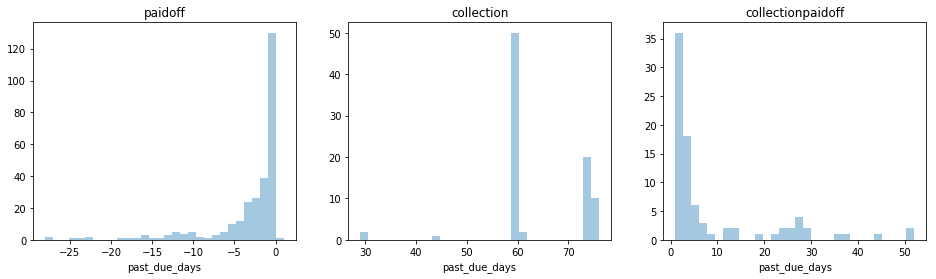

In [24]:
# visualizing continuous variables
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(df[df['loan_status']=='PAIDOFF'].past_due_days, bins = 30, ax = axes[0], kde = False)
ax.set_title('paidoff')
ax = sns.distplot(df[df['loan_status']=='COLLECTION'].past_due_days, bins = 30, ax = axes[1], kde = False)
ax.set_title('collection')
ax = sns.distplot(df[df['loan_status']=='COLLECTION_PAIDOFF'].past_due_days, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('collectionpaidoff')

In [25]:
# storing target variable
y=df['loan_status']

In [26]:
# removing unnecessary columns
del df['Loan_ID']
del df['loan_status']

In [27]:
# encoding categorical values
lb1=LabelEncoder()
lb2=LabelEncoder()
lb3=LabelEncoder()
df['Gender']=lb1.fit_transform(df['Gender'])
df['education']=lb2.fit_transform(df['education'])
y=lb3.fit_transform(y)

In [28]:
# remove features lowering average cross validation test accuracy
del df['due_date']
del df['paid_off_time']
del df['effective_date']
del df['age']
del df['education']
del df['month']
del df['day']

In [29]:
# initializing model
model=RandomForestClassifier(n_jobs=-1,random_state=0,n_estimators=10)
# model=DecisionTreeClassifier(random_state=0,max_depth=4)

In [30]:
# stratified split to balance classes 
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(df, y)
testacc=0
trainacc=0
for train_index, test_index in skf.split(df, y):
    X_train, X_test = df.values[train_index], df.values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model=model.fit(X_train,y_train)
    testacc+=(accuracy_score(model.predict(X_test),y_test))
    trainacc+=(accuracy_score(model.predict(X_train),y_train))
print(trainacc/5)    
print(testacc/5)    

0.9966942148760329
0.988913308913309


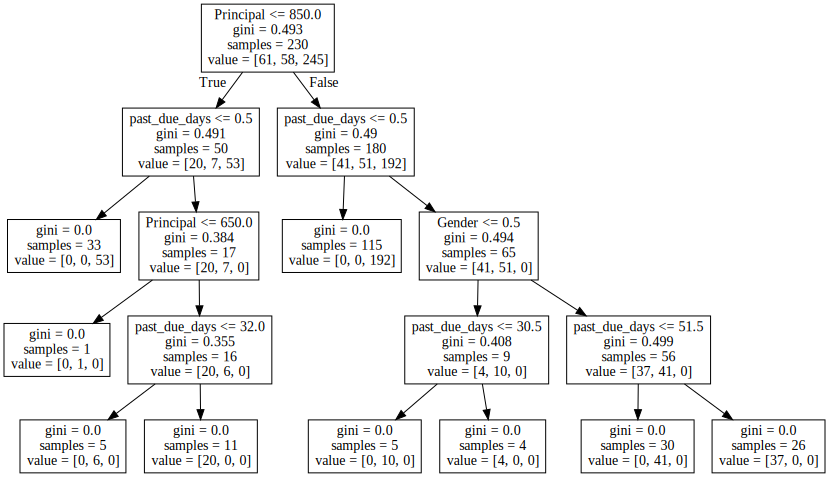

In [31]:
# visualizing a decision tree from the rf model
graph = Source( tree.export_graphviz(model.estimators_[0], out_file=None, feature_names=df.columns))
SVG(graph.pipe(format='svg'))

In [32]:
importances = model.feature_importances_
indices = np.argsort(importances)
features=df.columns

Text(0.5,0,'Relative Importance')

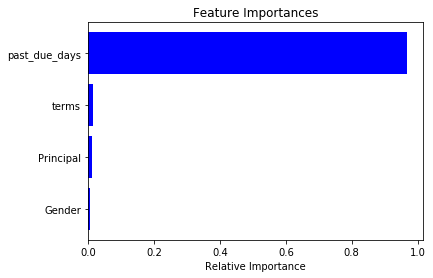

In [33]:
# feature importances
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [34]:
# test set evaluation
test=pd.read_csv('test.csv')
test['due_date']=pd.to_datetime(test['due_date'])
test['past_due_days']=pd.to_timedelta(test['past_due_days'],unit='D')
test['paid_off_time']=pd.to_datetime(test['paid_off_time'])
test['effective_date']=pd.to_datetime(test['effective_date'])
test=test.fillna('nan')
test['paid_off_time']=test.apply(replace_missing_dates,axis=1)
test['past_due_days']=test.apply(replace_missing_days,axis=1)
del test['Loan_ID']
del test['due_date']
del test['paid_off_time']
del test['effective_date']
del test['age']
del test['education']
test['Gender']=lb1.transform(test['Gender'])
actual=test['loan_status']
actual=lb3.transform(actual)
del test['loan_status']
predictions=model.predict(test)
print(accuracy_score(predictions,actual))